## 1. 데이터 로드 및 전처리

In [100]:
import os
import pickle
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd



def load_data(dataset):
    
    weekday_day_df = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/weekday_re_df_1021.pkl')

    adj = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/adjacency_1020.pkl')
    adj = adj.values

    spatial_feature = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/spatial_feature_1021_scaled.pkl')
    spatial_feature=spatial_feature.iloc[:,[0,1,2,3, 7,8,9,10,11,12,14]].values

    
    weekday_weather_df = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/weekday_weather_df.pkl')

    # Min-Max 스케일링 객체 생성
    scaler = MinMaxScaler()

    # Min-Max 스케일링 적용
    adj = scaler.fit_transform(adj)

    # 라플라시안 행렬 적용하기
    adj = np.array(adj)

    D̃ = np.diag(np.sum(adj, axis=1))
    D̃_sqrt_inv = np.sqrt(np.linalg.inv(D̃))
    # D̃(-1/2) Ã D̃(-1/2) 계산
    adj = np.dot(np.dot(D̃_sqrt_inv, adj), D̃_sqrt_inv)

    return adj, weekday_day_df, spatial_feature, weekday_weather_df


## GCN 모델 구성 

In [101]:
# GCN model

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Func



class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, acti=True):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim) # bias = False is also ok.
        if acti:
            self.acti = nn.ReLU(inplace=True)
        else:
            self.acti = None
    def forward(self, F):
        output = self.linear(F)
        if not self.acti:
            return output
        return self.acti(output)


class GCN(nn.Module):
    def __init__(self, input_dim,dropout):
        super(GCN, self).__init__()
        self.gcn_layer1 = GCNLayer(input_dim, input_dim)
        self.gcn_layer2 = GCNLayer(input_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, A, X):
        A = A.float()
        X = X.float()
        F = torch.mm(A, X)
        F = self.gcn_layer1(F)
        F = torch.mm(A, F)
        output = self.gcn_layer2(F)
        output = output.float()
        return output

class FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


## Loss function, Optimizer 생성

In [102]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.loss = nn.MSELoss(reduction='mean')  # 평균 제곱 오차로 변경
    def forward(self, output, y):
        loss = self.loss(output, y)
        return torch.sqrt(loss)

# 레이어마다 다르게 optimizer을 구성하는 이유는 각 레이어마다 learning rate, weight decay을 다르게 조정하고 싶을 때 쓴다. 이 부분 교수님께 물어본다.
def build_optimizer(model, lr, weight_decay):
    gcn1, gcn2 = [], []
    for name, p in model.named_parameters():
        if 'layer1' in name:
            gcn1.append(p)
        else:
            gcn2.append(p)
    opt = optim.Adam([{'params': gcn1, 'weight_decay': weight_decay},
                      {'params': gcn2}
                      ], lr=lr)
    return opt


def get_lr():
    pass


def get_loss(output, y):
    loss = Loss()
    return loss(output, y)

def get_mse(outputs, y):
    loss = Loss()
    return loss(outputs,y)

def get_loss2(output, y):
    loss_module = Loss()
    loss_values = [loss_module(torch.tensor(output[i], dtype=torch.float), torch.tensor(y[i], dtype=torch.float)) for i in range(len(output))]
    return loss_values


## GCN-pro 코드
### GCN-UP도 함께 가능(spatial feature 조정)

In [103]:
# GCN - pro

import argparse
import os
import torch
import torch.optim as optim
import pandas as pd
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

adj,weekday_day_df,spatial_feature, weekday_weather_df = load_data('citeseer')

adj = torch.from_numpy(adj).to('cuda')

def build_optimizer(model, lr, weight_decay):
    gcn1, gcn2 = [], []
    for name, p in model.named_parameters():
        if 'layer1' in name:
            gcn1.append(p)
        else:
            gcn2.append(p)
    opt = optim.Adam([{'params': gcn1, 'weight_decay': weight_decay},
                      {'params': gcn2}
                      ], lr=lr)
    return opt

def train_1115_GCN_pro(dropout, day, week, epoch, lr):

    gcn_model_rental_day = GCN(day,dropout)
    gcn_model_rental_week = GCN(week*5,dropout)
    gcn_model_spatial = GCN(11,dropout)
    fcn_model = FCN((day+week*5+11)*2709+2, 32,64, 2709)

    gcn_model_rental_day.to('cuda')
    gcn_model_rental_week.to('cuda')
    gcn_model_spatial.to('cuda')
    fcn_model.to('cuda')

    # GCN 모델에 대한 옵티마이저 설정
    optimizer_gcn_rental_day = build_optimizer(gcn_model_rental_day, lr, 0)
    optimizer_gcn_rental_week = build_optimizer(gcn_model_rental_week, lr, 0)
    optimizer_gcn_model_spatial = build_optimizer(gcn_model_spatial, lr, 0)

    # FCN 모델에 대한 옵티마이저 설정
    optimizer_fcn = optim.Adam(fcn_model.parameters(), lr=lr)
    optimizers = [optimizer_gcn_rental_day,optimizer_gcn_rental_week,optimizer_gcn_model_spatial, optimizer_fcn]


    for epoch in range(epoch + 1):
        for optimizer in optimizers:
            optimizer.zero_grad()
        total_loss = []
        k_days = day
        k_weeks = week

        for i in range(41,174):

            # 일별 대여량 연산
            features1 = weekday_day_df.iloc[:,i-k_days:i]
            features1 = pd.DataFrame(features1)
            features1.index = range(2709)

            features1 = features1.values
            features1 = features1.astype(float)
            features1 = torch.from_numpy(features1)
            features1 = features1.to('cuda')

            gcn_output_rental_day = gcn_model_rental_day(adj, features1)
            flattened_gcn_output_rental_day = gcn_output_rental_day.view(1, -1)


            # 주별 대여량 연산
            features2 = weekday_day_df.iloc[:,i-k_weeks*5:i]
            features2 = pd.DataFrame(features2)
            features2.index = range(2709)

            features2 = features2.values
            features2 = features2.astype(float)
            features2 = torch.from_numpy(features2)
            features2 = features2.to('cuda')

            gcn_output_rental_week = gcn_model_rental_week(adj, features2)
            flattened_gcn_output_rental_week = gcn_output_rental_week.view(1, -1)

            #공간 특성 연산
            spatial_feature1 = pd.DataFrame(spatial_feature)
            spatial_feature1.index = range(2709)

            spatial_feature1 = spatial_feature1.values
            spatial_feature1 = spatial_feature1.astype(float)
            spatial_feature1 = torch.from_numpy(spatial_feature1)
            spatial_feature1 = spatial_feature1.to('cuda')

            gcn_output_spatial = gcn_model_spatial(adj, spatial_feature1)
            flattened_gcn_output_spatial = gcn_output_spatial.view(1, -1)


            y = weekday_day_df.iloc[:,i]
            y = y.values.flatten()
            y = torch.from_numpy(y).float()
            y = y.view(1, -1)
            y = y.to('cuda')

            weather_value = torch.from_numpy(weekday_weather_df.iloc[i,[2,4]].astype(float).to_numpy().reshape(1, -1)).float().to('cuda')

#             flattened_gcn_output와 weather_value를 concatenate
            input_tensor = torch.cat((flattened_gcn_output_rental_day,flattened_gcn_output_rental_week,
                                      flattened_gcn_output_spatial, weather_value), dim=1)

         
            input_tensor.to('cuda')

            fcn_output = fcn_model(input_tensor)

            loss = get_loss(fcn_output, y)
            node_loss = torch.mean(loss)

            node_loss.backward(retain_graph=False)
            for optimizer in optimizers:
                optimizer.step()

            total_loss.append(loss)

            # del features1, features2, spatial_feature1,y,weather_value,input_tensor, gcn_output_rental_day, flattened_gcn_output_rental_day, gcn_output_rental_week, flattened_gcn_output_rental_week, gcn_output_spatial, flattened_gcn_output_spatial, fcn_output
            torch.cuda.empty_cache()

        if epoch%100 == 0:
        	print('epoch: ', epoch)
        
    # Test set
    test_loss_list = []
    test_station_loss_list = []
    prediction_list = []
    for evaluate_day_num in range(173, 195):
        # 일별 대여량 연산
        features1 = weekday_day_df.iloc[:,evaluate_day_num-k_days:evaluate_day_num]
        features1 = pd.DataFrame(features1)
        features1.index = range(2709)

        features1 = features1.values
        features1 = features1.astype(float)
        features1 = torch.from_numpy(features1)
        features1 = features1.to('cuda')

        gcn_output_rental_day = gcn_model_rental_day(adj, features1)
        flattened_gcn_output_rental_day = gcn_output_rental_day.view(1, -1)

        # 주별 대여량 연산
        features2 = weekday_day_df.iloc[:,evaluate_day_num-k_weeks*5:evaluate_day_num]
        features2 = pd.DataFrame(features2)
        features2.index = range(2709)

        features2 = features2.values
        features2 = features2.astype(float)
        features2 = torch.from_numpy(features2)
        features2 = features2.to('cuda')

        gcn_output_rental_week = gcn_model_rental_week(adj, features2)
        flattened_gcn_output_rental_week = gcn_output_rental_week.view(1, -1)

        # 공간 특성 연산
        spatial_feature1 = pd.DataFrame(spatial_feature)
        spatial_feature1.index = range(2709)

        spatial_feature1 = spatial_feature1.values
        spatial_feature1 = spatial_feature1.astype(float)
        spatial_feature1 = torch.from_numpy(spatial_feature1)
        spatial_feature1 = spatial_feature1.to('cuda')

        gcn_output_spatial = gcn_model_spatial(adj, spatial_feature1)
        flattened_gcn_output_spatial = gcn_output_spatial.view(1, -1)


        y = weekday_day_df.iloc[:,evaluate_day_num]
        y = y.values.flatten()
        y = torch.from_numpy(y).float()
        y = y.view(1, -1)
        y = y.to('cuda')


        weather_value =torch.from_numpy(weekday_weather_df.iloc[evaluate_day_num,[2,4]].astype(float).to_numpy().reshape(1, -1)).float().to('cuda')


        input_tensor = torch.cat((flattened_gcn_output_rental_day,flattened_gcn_output_rental_week,
                                    flattened_gcn_output_spatial, weather_value), dim=1)


        input_tensor.to('cuda')

        fcn_output = fcn_model(input_tensor)

        prediction=fcn_output.squeeze().to('cpu')
        prediction_list.append(prediction)
        # get_loss2을 통해 각 거치소마다의 loss값을 정리하였다.
        loss_list = get_loss2(fcn_output.squeeze(), y.squeeze())
        loss_list_cpu = [loss_item.to('cpu') for loss_item in loss_list]
        loss_avg = sum(loss_list_cpu)/len(loss_list_cpu)
        
        test_loss_list.append(loss_avg)
        test_station_loss_list.append(loss_list_cpu)
    
    test_loss_avg = sum(test_loss_list)/len(test_loss_list)
    
    torch.cuda.empty_cache()

    return test_loss_avg, test_station_loss_list, prediction_list

print('훈련 시작합니다.')
if __name__ == '__main__':
 
    loss_GCN_pro, loss_station, prediction = train_1115_GCN_pro(1, 3, 4, 300, 0.001)



cuda:0
훈련 시작합니다.
epoch:  0
epoch:  100
epoch:  200
epoch:  300


/tmp/ipykernel_757643/32709490.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_values = [loss_module(torch.tensor(output[i], dtype=torch.float), torch.tensor(y[i], dtype=torch.float)) for i in range(len(output))]
/tmp/ipykernel_757643/32709490.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_values = [loss_module(torch.tensor(output[i], dtype=torch.float), torch.tensor(y[i], dtype=torch.float)) for i in range(len(output))]
/tmp/ipykernel_757643/32709490.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_values = 

In [108]:
loss_GCN_pro

tensor(14.1962)

### Process 1:GCN-pro 결과 시각화

#### RMSE: 14.196

In [110]:
loss_GCN_pro

tensor(14.1962)

In [111]:
station_id = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/adjacency_1020.pkl').columns.to_list()
test_date= weekday_day_df.iloc[:,173:195].columns.to_list()

In [112]:
rmse_df = pd.DataFrame(index =station_id ,columns=test_date)

In [113]:
for i,rmse_by_day in enumerate(loss_station):
    for j,prediction_element in enumerate(rmse_by_day):
        rmse_df.iloc[j,i] = prediction_element.item()

In [114]:
rmse_df['prediction_mean'] = rmse_df.mean(axis=1)
rmse_df

,2022-09-01,2022-09-02,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,2022-09-14,...,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,prediction_mean
102,23.510071,8.391068,28.997099,75.148987,1.516556,16.174332,76.266724,5.661011,22.266724,10.023392,...,41.497513,11.425278,17.083084,60.753708,29.911987,27.642014,9.430237,17.569763,10.813095,25.600056
103,22.480606,14.926758,16.125919,57.742065,10.572906,8.542145,32.95752,21.504013,12.95752,7.434464,...,4.296005,0.165543,2.19632,3.096016,12.7883,23.78093,4.242462,9.242462,5.765533,16.732689
104,24.435158,17.924522,8.66934,3.606735,21.662529,2.296631,20.709579,5.252213,7.290421,16.015999,...,9.684715,8.227333,7.593231,23.105545,0.776184,7.599457,13.85791,12.14209,9.583488,10.638748
105,25.673409,11.473457,6.57237,11.932602,4.301903,10.759071,24.016289,15.555168,24.016289,22.359169,...,3.012573,9.415962,13.873131,2.102234,3.101715,13.130348,13.558891,13.558891,1.098236,13.4775
106,2.700623,41.139618,14.349778,42.290543,2.998215,13.767639,17.373749,91.916428,30.626251,45.551865,...,32.949295,4.491974,9.742157,14.9823,5.640778,26.863937,39.406631,41.593369,1.518997,25.991619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5859,0.605528,0.615247,0.379269,0.488287,0.588867,0.594421,0.609694,0.602752,0.609694,0.61386,...,0.548603,0.541661,0.547215,0.566295,0.549992,0.562487,0.555547,0.555547,0.559711,0.567164
5860,1.080042,1.06008,0.653219,0.977538,1.114263,1.102857,1.071487,1.085746,1.071487,1.062933,...,1.196964,1.211222,1.199817,1.425298,1.194112,1.168446,1.182706,1.182706,1.17415,1.12092
5861,4.846866,4.989508,1.668125,2.893285,4.602334,4.683845,4.907999,4.806111,4.907999,4.969133,...,4.011384,3.909495,3.991007,3.367693,4.031762,4.21516,4.113274,4.113274,4.174405,4.217519
5862,6.34983,6.528794,2.503478,3.910539,6.043031,6.145296,6.426528,6.298696,6.426528,6.503229,...,5.3016,5.173768,5.276033,4.242085,5.327166,5.557266,5.429432,5.429432,5.506134,5.549875


In [115]:
rmse_df.to_csv('rmse_GCN_pro_231216.csv')

In [116]:
prediction_df = pd.DataFrame(index =station_id ,columns=test_date)

In [123]:
for i,prediction_by_day in enumerate(prediction):
    for j,prediction_element in enumerate(prediction_by_day):
        prediction_df.iloc[j,i] = prediction_element.item()

In [124]:
prediction_df_T=prediction_df.T
prediction_df_T['prediction_mean'] = prediction_df_T.mean(axis=1)
prediction_df_T = pd.concat([prediction_df_T['prediction_mean'], prediction_df_T.drop('prediction_mean', axis=1)], axis=1)
prediction_df_T.to_csv('prediction_GCN_pro_231216.csv')
prediction_df_T

,prediction_mean,102,103,104,105,106,107,108,109,111,...,5853,5854,5855,5857,5858,5859,5860,5861,5862,6053
2022-09-01,69.019115,199.510071,161.480606,86.435158,59.673409,160.700623,113.140862,106.138817,71.673576,57.349911,...,17.545321,51.062477,18.241844,2.615858,-1.268855,0.605528,-1.080042,4.846866,6.34983,-1.180438
2022-09-02,70.466551,203.608932,164.926758,87.075478,60.473457,162.860382,115.916229,108.386086,72.902466,57.887341,...,18.695387,54.12878,19.446331,2.912585,-1.325546,0.615247,-1.06008,4.989508,6.528794,-1.146671
2022-09-05,10.003933,28.997099,20.125919,9.66934,6.57237,15.349778,16.87369,18.12167,9.815384,8.931755,...,4.397302,9.052195,3.066603,1.345128,-0.527892,0.379269,-0.653219,1.668125,2.503478,0.012903
2022-09-06,30.166295,84.851013,64.257935,57.393265,33.067398,84.709457,41.184921,42.536148,33.82935,35.100094,...,-2.7776,-7.50157,-2.851189,-2.112851,-0.551287,0.488287,-0.977538,2.893285,3.910539,-1.111622
2022-09-07,66.537793,192.483444,155.572906,85.337471,58.301903,156.998215,108.383102,102.286362,69.566925,56.428604,...,15.573782,45.805954,16.177011,2.107184,-1.171671,0.588867,-1.114263,4.602334,6.043031,-1.238325
2022-09-08,67.364903,194.825668,157.542145,85.703369,58.759071,158.232361,109.969025,103.570518,70.26915,56.735706,...,16.230961,47.558128,16.86529,2.276742,-1.204065,0.594421,-1.102857,4.683845,6.145296,-1.219029
2022-09-09,69.639444,201.266724,162.95752,86.709579,60.016289,161.626251,114.330315,107.101929,72.200249,57.580238,...,18.038206,52.376606,18.758053,2.743027,-1.293151,0.609694,-1.071487,4.907999,6.426528,-1.165968
2022-09-12,68.60556,198.338989,160.495987,86.252213,59.444832,160.083572,112.347908,105.496742,71.322472,57.196362,...,17.21673,50.186382,17.897703,2.531079,-1.252657,0.602752,-1.085746,4.806111,6.298696,-1.190085
2022-09-13,69.639444,201.266724,162.95752,86.709579,60.016289,161.626251,114.330315,107.101929,72.200249,57.580238,...,18.038206,52.376606,18.758053,2.743027,-1.293151,0.609694,-1.071487,4.907999,6.426528,-1.165968
2022-09-14,70.259778,203.023392,164.434464,86.984001,60.359169,162.551865,115.51976,108.065056,72.726913,57.810566,...,18.531094,53.690739,19.274263,2.870196,-1.317447,0.61386,-1.062933,4.969133,6.503229,-1.151495


In [125]:
prediction_df_T.mean()

prediction_mean     60.372701
102                174.701875
103                140.665839
104                 79.785851
105                 53.741265
                      ...    
5859                 0.567164
5860                 -1.12092
5861                 4.217519
5862                 5.549875
6053                -1.218355
Length: 2710, dtype: object

In [180]:
adj,weekday_day_df,spatial_feature, weekday_weather_df = load_data('citeseer')

In [181]:
actual_df = weekday_day_df.iloc[:,173:195]
actual_df.index = station_id

In [182]:
# actual_df['station_mean']=actual_df.mean(axis=1)
# actual_df.sort_values('station_mean')

In [183]:
actual_df_T=actual_df.T

In [184]:
actual_df_T['y_mean'] = actual_df_T.mean(axis=1)
actual_df_T = pd.concat([actual_df_T['y_mean'], actual_df_T.drop('y_mean', axis=1)], axis=1)
actual_df_T

,y_mean,102,103,104,105,106,107,108,109,111,...,5853,5854,5855,5857,5858,5859,5860,5861,5862,6053
2022-09-01,64.975268,176,139,62,34,158,97,74,66,46,...,75,245,79,76,0,0,0,0,0,0
2022-09-02,67.961979,212,150,105,49,204,109,82,82,54,...,69,276,127,82,0,0,0,0,0,0
2022-09-05,1.876338,0,4,1,0,1,2,5,1,1,...,2,2,1,2,0,0,0,0,0,0
2022-09-06,51.652639,160,122,61,45,127,92,76,42,30,...,65,171,91,54,0,0,0,0,0,0
2022-09-07,65.178295,194,145,107,54,154,99,113,65,51,...,80,266,106,85,0,0,0,0,0,0
2022-09-08,66.602067,211,149,88,48,172,104,87,60,43,...,93,272,106,78,0,0,0,0,0,0
2022-09-09,44.765596,125,130,66,36,179,54,77,47,34,...,33,168,68,70,0,0,0,0,0,0
2022-09-12,55.143595,204,182,81,75,252,69,67,60,73,...,30,287,61,73,0,0,0,0,0,0
2022-09-13,60.741971,179,150,94,36,131,117,71,58,38,...,74,263,81,71,0,0,0,0,0,0
2022-09-14,65.140642,193,157,103,38,117,108,75,59,35,...,78,262,111,87,0,0,0,0,0,0


In [185]:
actual_df_T.to_csv('actual_septemper_rental_record_mean.csv')

In [186]:
prediction_df_T['날짜']=prediction_df_T.index
actual_df_T['날짜']=actual_df_T.index

In [187]:
actual_df_T

,y_mean,102,103,104,105,106,107,108,109,111,...,5854,5855,5857,5858,5859,5860,5861,5862,6053,날짜
2022-09-01,64.975268,176,139,62,34,158,97,74,66,46,...,245,79,76,0,0,0,0,0,0,2022-09-01
2022-09-02,67.961979,212,150,105,49,204,109,82,82,54,...,276,127,82,0,0,0,0,0,0,2022-09-02
2022-09-05,1.876338,0,4,1,0,1,2,5,1,1,...,2,1,2,0,0,0,0,0,0,2022-09-05
2022-09-06,51.652639,160,122,61,45,127,92,76,42,30,...,171,91,54,0,0,0,0,0,0,2022-09-06
2022-09-07,65.178295,194,145,107,54,154,99,113,65,51,...,266,106,85,0,0,0,0,0,0,2022-09-07
2022-09-08,66.602067,211,149,88,48,172,104,87,60,43,...,272,106,78,0,0,0,0,0,0,2022-09-08
2022-09-09,44.765596,125,130,66,36,179,54,77,47,34,...,168,68,70,0,0,0,0,0,0,2022-09-09
2022-09-12,55.143595,204,182,81,75,252,69,67,60,73,...,287,61,73,0,0,0,0,0,0,2022-09-12
2022-09-13,60.741971,179,150,94,36,131,117,71,58,38,...,263,81,71,0,0,0,0,0,0,2022-09-13
2022-09-14,65.140642,193,157,103,38,117,108,75,59,35,...,262,111,87,0,0,0,0,0,0,2022-09-14


In [188]:
prediction_df_T

,prediction_mean,102,103,104,105,106,107,108,109,111,...,5854,5855,5857,5858,5859,5860,5861,5862,6053,날짜
2022-09-01,69.019115,199.510071,161.480606,86.435158,59.673409,160.700623,113.140862,106.138817,71.673576,57.349911,...,51.062477,18.241844,2.615858,-1.268855,0.605528,-1.080042,4.846866,6.34983,-1.180438,2022-09-01
2022-09-02,70.466551,203.608932,164.926758,87.075478,60.473457,162.860382,115.916229,108.386086,72.902466,57.887341,...,54.12878,19.446331,2.912585,-1.325546,0.615247,-1.06008,4.989508,6.528794,-1.146671,2022-09-02
2022-09-05,10.003933,28.997099,20.125919,9.66934,6.57237,15.349778,16.87369,18.12167,9.815384,8.931755,...,9.052195,3.066603,1.345128,-0.527892,0.379269,-0.653219,1.668125,2.503478,0.012903,2022-09-05
2022-09-06,30.166295,84.851013,64.257935,57.393265,33.067398,84.709457,41.184921,42.536148,33.82935,35.100094,...,-7.50157,-2.851189,-2.112851,-0.551287,0.488287,-0.977538,2.893285,3.910539,-1.111622,2022-09-06
2022-09-07,66.537793,192.483444,155.572906,85.337471,58.301903,156.998215,108.383102,102.286362,69.566925,56.428604,...,45.805954,16.177011,2.107184,-1.171671,0.588867,-1.114263,4.602334,6.043031,-1.238325,2022-09-07
2022-09-08,67.364903,194.825668,157.542145,85.703369,58.759071,158.232361,109.969025,103.570518,70.26915,56.735706,...,47.558128,16.86529,2.276742,-1.204065,0.594421,-1.102857,4.683845,6.145296,-1.219029,2022-09-08
2022-09-09,69.639444,201.266724,162.95752,86.709579,60.016289,161.626251,114.330315,107.101929,72.200249,57.580238,...,52.376606,18.758053,2.743027,-1.293151,0.609694,-1.071487,4.907999,6.426528,-1.165968,2022-09-09
2022-09-12,68.60556,198.338989,160.495987,86.252213,59.444832,160.083572,112.347908,105.496742,71.322472,57.196362,...,50.186382,17.897703,2.531079,-1.252657,0.602752,-1.085746,4.806111,6.298696,-1.190085,2022-09-12
2022-09-13,69.639444,201.266724,162.95752,86.709579,60.016289,161.626251,114.330315,107.101929,72.200249,57.580238,...,52.376606,18.758053,2.743027,-1.293151,0.609694,-1.071487,4.907999,6.426528,-1.165968,2022-09-13
2022-09-14,70.259778,203.023392,164.434464,86.984001,60.359169,162.551865,115.51976,108.065056,72.726913,57.810566,...,53.690739,19.274263,2.870196,-1.317447,0.61386,-1.062933,4.969133,6.503229,-1.151495,2022-09-14


In [198]:
merged_df = pd.merge(prediction_df_T.loc[:,['prediction_mean',2715,4217,502,'날짜']], actual_df_T.loc[:,['y_mean',2715,4217,502,'날짜']], on='날짜', how='inner')
merged_df['날짜'] = pd.to_datetime(merged_df['날짜'])
merged_df


,prediction_mean,2715_x,4217_x,502_x,날짜,y_mean,2715_y,4217_y,502_y
0,69.019115,725.351501,560.246094,602.663818,2022-09-01,64.975268,718,702,720
1,70.466551,743.859741,572.438477,615.632385,2022-09-02,67.961979,708,766,911
2,10.003933,88.189453,49.850883,55.495003,2022-09-05,1.876338,14,7,6
3,30.166295,251.747849,220.080612,241.856476,2022-09-06,51.652639,551,182,448
4,66.537793,693.623169,539.344849,580.432007,2022-09-07,65.178295,692,472,659
5,67.364903,704.199341,546.311951,587.842651,2022-09-08,66.602067,720,629,712
6,69.639444,733.283569,565.471436,608.221741,2022-09-09,44.765596,321,990,899
7,68.60556,720.063416,556.762512,598.958496,2022-09-12,55.143595,439,1160,1031
8,69.639444,733.283569,565.471436,608.221741,2022-09-13,60.741971,643,427,492
9,70.259778,741.21582,570.696716,613.779724,2022-09-14,65.140642,647,446,531


Text(0, 0.5, 'Mean of rental bike frequency')

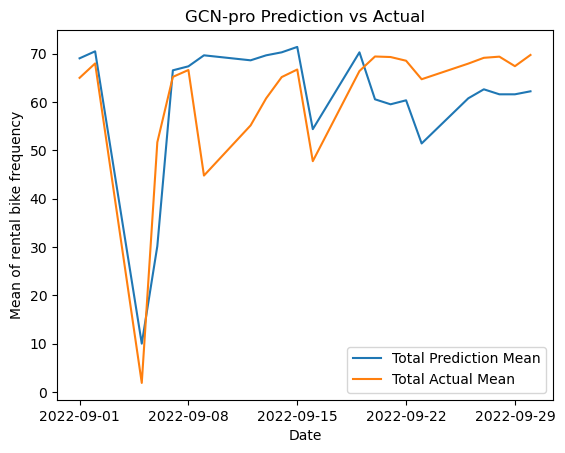

In [199]:
# 꺾은선 그래프 그리기
import matplotlib.pyplot as plt

dates= merged_df['날짜'].to_numpy()
plt.plot(dates, merged_df['prediction_mean'].to_numpy(), label='Total Prediction Mean')
plt.plot(dates, merged_df['y_mean'].to_numpy(), label='Total Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
# 그래프 제목과 레이블 설정
plt.title('GCN-pro Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Mean of rental bike frequency')

Text(0, 0.5, 'Rental bike frequency')

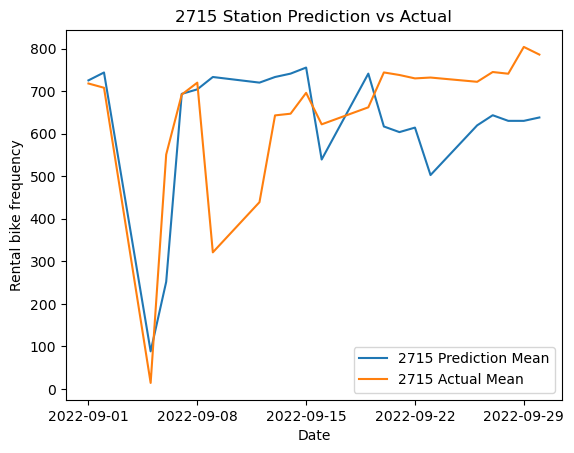

In [204]:
# 꺾은선 그래프 그리기
import matplotlib.pyplot as plt

dates= merged_df['날짜'].to_numpy()
plt.plot(dates, merged_df['2715_x'].to_numpy(), label='2715 Prediction Mean')
plt.plot(dates, merged_df['2715_y'].to_numpy(), label='2715 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
# 그래프 제목과 레이블 설정
plt.title('2715 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

Text(0, 0.5, 'Rental bike frequency')

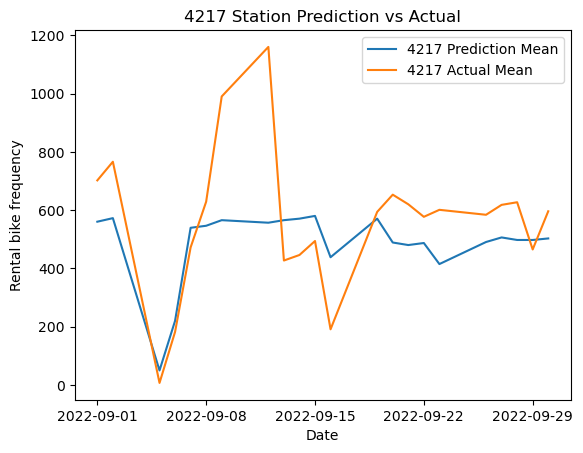

In [205]:
# 꺾은선 그래프 그리기
import matplotlib.pyplot as plt

dates= merged_df['날짜'].to_numpy()
plt.plot(dates, merged_df['4217_x'].to_numpy(), label='4217 Prediction Mean')
plt.plot(dates, merged_df['4217_y'].to_numpy(), label='4217 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
# 그래프 제목과 레이블 설정
plt.title('4217 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

Text(0, 0.5, 'Rental bike frequency')

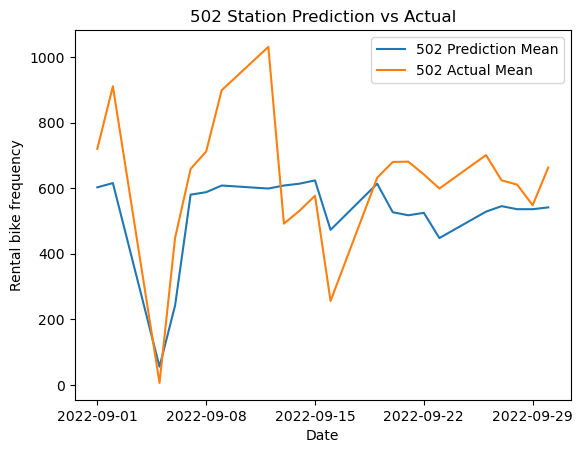

In [206]:
# 꺾은선 그래프 그리기
import matplotlib.pyplot as plt

dates= merged_df['날짜'].to_numpy()
plt.plot(dates, merged_df['502_x'].to_numpy(), label='502 Prediction Mean')
plt.plot(dates, merged_df['502_y'].to_numpy(), label='502 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
# 그래프 제목과 레이블 설정
plt.title('502 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

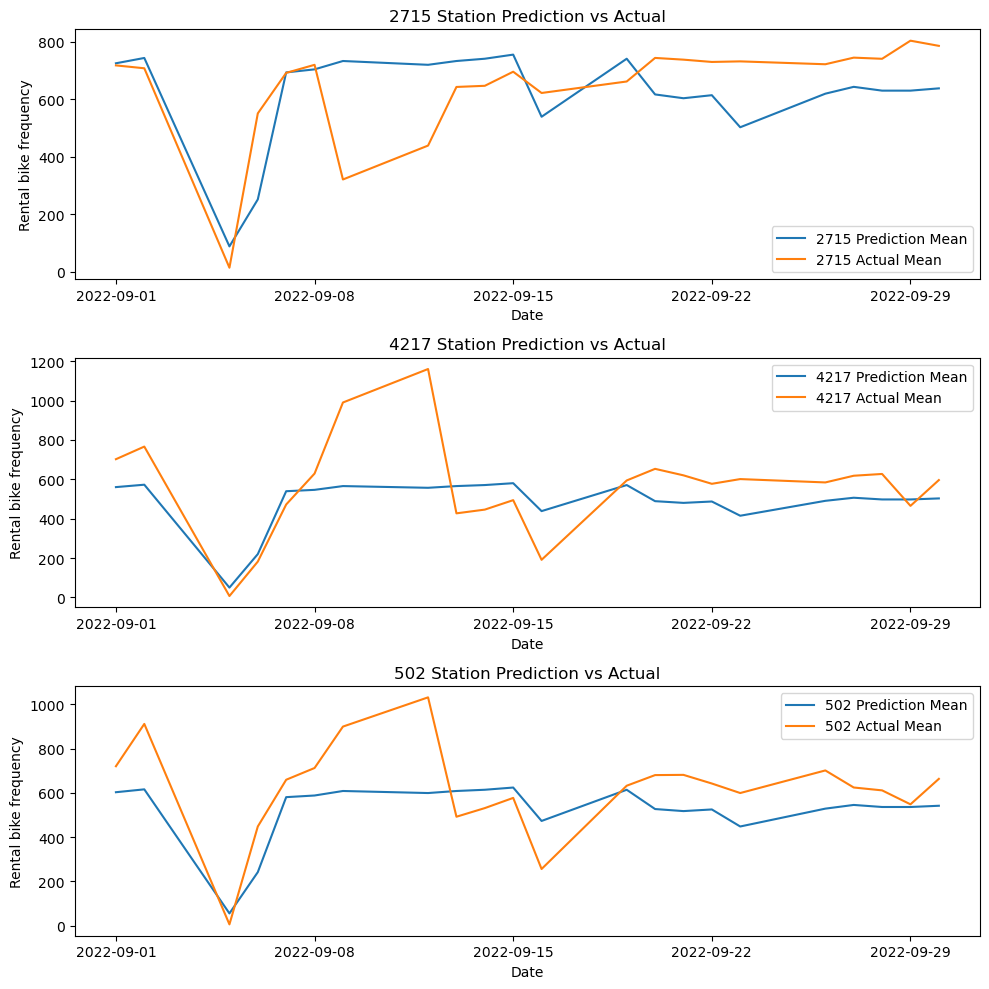

In [215]:
import matplotlib.pyplot as plt

# 그림 크기 및 서브플롯 설정
plt.figure(figsize=(10, 10))

# 2715 Station 그래프
plt.subplot(3, 1, 1)
plt.plot(dates, merged_df['2715_x'].to_numpy(), label='2715 Prediction Mean')
plt.plot(dates, merged_df['2715_y'].to_numpy(), label='2715 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
plt.title('2715 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

# 4217 Station 그래프
plt.subplot(3, 1, 2)
plt.plot(dates, merged_df['4217_x'].to_numpy(), label='4217 Prediction Mean')
plt.plot(dates, merged_df['4217_y'].to_numpy(), label='4217 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
plt.title('4217 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

# 502 Station 그래프
plt.subplot(3, 1, 3)
plt.plot(dates, merged_df['502_x'].to_numpy(), label='502 Prediction Mean')
plt.plot(dates, merged_df['502_y'].to_numpy(), label='502 Actual Mean')
plt.xticks(dates[::5], rotation=0)
plt.legend()
plt.title('502 Station Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Rental bike frequency')

# 레이아웃 조정
plt.tight_layout()

# 그림 저장 또는 출력
plt.savefig('combined_plots.png')
plt.show()


### Process 2: 공간행렬 분석

In [203]:
station_id=list(weekday_day_df.index)

In [80]:
adj,weekday_day_df,spatial_feature, weekday_weather_df = load_data('citeseer')

In [81]:
test_date= weekday_day_df.iloc[:,173:195].columns.to_list()

In [347]:
# 데이터프레임 생성
df = pd.DataFrame(index =station_id ,columns=test_date)


In [348]:
# 각 날짜에 대해 station 열 생성
for i, period in enumerate(loss_station):
    for j, station in enumerate(period):
        df.iloc[j,i] = station.item()

In [354]:
df

,2022-09-01,2022-09-02,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,2022-09-14,...,2022-09-19,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
3,34.353714,2.978516,7.47458,79.930328,8.425491,5.931732,87.33577,5.032333,33.33577,21.31781,...,9.31781,32.558517,2.427597,8.132324,82.457932,20.984695,18.820404,18.310532,8.689468,1.968002
4,32.722137,25.482666,2.898232,65.185997,20.275528,18.424408,43.333786,11.35231,23.333786,17.945435,...,48.945435,13.209686,8.713287,6.710403,20.550934,21.708984,14.797501,4.706085,0.293915,3.203949
5,29.454597,11.655487,7.744061,27.861782,18.785255,1.294716,26.264565,9.914619,1.735435,9.925476,...,1.074524,8.233856,6.197472,6.026588,43.858624,0.558853,7.306656,14.729736,11.270264,10.107903
6,29.148987,15.443039,6.535103,23.611357,6.930603,13.670067,27.703575,12.220749,27.703575,26.258171,...,13.258171,2.067291,10.142548,14.774681,9.700653,4.090744,14.513023,14.72287,14.72287,0.19696
7,15.876846,26.350616,7.622611,66.206589,13.409653,2.434586,3.506363,79.201019,44.493637,60.110443,...,38.110443,26.184677,2.241745,16.500626,52.147423,1.130051,20.037476,32.611069,48.388931,8.333069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,0.558033,0.559295,0.489852,0.374252,0.555871,0.556592,0.558574,0.557673,0.558574,0.559114,...,0.559114,0.396831,0.339109,0.385287,0.477775,0.408376,0.512277,0.454554,0.454554,0.489188
2752,0.395824,0.404359,0.075785,0.128083,0.381192,0.386069,0.399482,0.393385,0.399482,0.40314,...,0.40314,0.268009,0.233164,0.26104,0.116733,0.274978,0.337701,0.302855,0.302855,0.323763
2753,1.008509,1.051644,0.816091,0.91784,0.934562,0.959211,1.026995,0.996184,1.026995,1.045482,...,1.045482,0.708328,0.659959,0.698654,0.239586,0.718002,0.805067,0.756698,0.756698,0.785719
2754,0.53679,0.558071,0.486727,0.30196,0.500309,0.512469,0.545911,0.53071,0.545911,0.555031,...,0.555031,0.803167,0.932416,0.829017,0.426242,0.777318,0.544668,0.673917,0.673917,0.596368


In [353]:
df.to_csv('loss_test_by_station.csv')

In [355]:
station_id = pd.read_pickle('/home/jhchoi/DS-capstone_1021/data/adjacency_1020.pkl').columns.to_list()

In [356]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

loss_by_station=pd.read_csv('loss_test_by_station.csv')
loss_by_station.rename(columns={loss_by_station.columns[0]: 'station_id'}, inplace=True)
loss_by_station['station_id']=station_id

In [357]:
loss_by_station.index = loss_by_station['station_id']
loss_by_station =loss_by_station.drop('station_id',axis =1)

In [358]:
loss_by_station['row_mean'] = loss_by_station.mean(axis=1)

loss_by_station_mean = pd.concat([loss_by_station['row_mean'], loss_by_station.drop('row_mean', axis=1)], axis=1)


In [366]:
loss_by_station_mean.mean()

row_mean      14.517760
2022-09-01    13.016575
2022-09-02    12.863234
2022-09-05     3.045304
2022-09-06    23.349862
2022-09-07    12.056904
2022-09-08    12.213688
2022-09-09    32.389002
2022-09-12    25.605817
2022-09-13    16.606077
2022-09-14    14.259207
2022-09-15    13.125139
2022-09-16     9.780656
2022-09-19    14.012463
2022-09-20    12.150360
2022-09-21    12.716972
2022-09-22    11.949850
2022-09-23    20.264825
2022-09-26    12.042043
2022-09-27    11.644826
2022-09-28    12.082081
2022-09-29    11.691004
2022-09-30    12.524832
dtype: float64

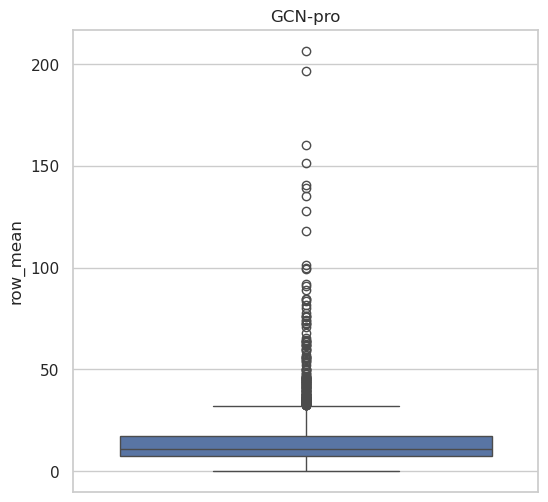

In [359]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

sns.boxplot(data=loss_by_station_mean, y='row_mean')
plt.title('GCN-pro')
plt.show()

In [360]:
loss_by_station_mean_list =loss_by_station_mean['row_mean'].to_list()

In [361]:
q1 = np.percentile(loss_by_station_mean_list, 25)
q3 = np.percentile(loss_by_station_mean_list, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [value for value in loss_by_station_mean_list if value < lower_bound or value > upper_bound]
print(len(outliers))

162


In [362]:
# outlier들만 있는 데이터프레임
loss_by_station_mean[loss_by_station_mean['row_mean'].isin(outliers)]

,row_mean,2022-09-01,2022-09-02,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,...,2022-09-19,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
station_id,,,,,,,,,,,,,,,,,,,,,
113,39.432632,47.918365,35.519379,1.789707,64.338593,23.602295,17.625641,140.747345,142.032318,40.747345,...,32.576355,0.444336,2.048401,6.365143,110.611816,4.523529,23.236267,25.840332,9.840332,61.077911
186,42.383869,10.406822,3.745316,8.026058,134.938568,13.397995,14.734291,136.590973,274.261322,43.409027,...,33.411240,20.431465,10.027641,6.150696,2.378220,14.712234,29.760887,31.835289,19.835289,29.322418
202,37.396449,8.282211,22.165375,4.581723,80.045631,14.236237,13.936615,67.661804,3.304214,28.338196,...,21.958588,37.997253,77.504501,74.698700,46.612381,129.295776,51.982742,29.490021,26.490021,22.385635
207,92.268536,21.951904,111.408630,2.179320,232.999710,19.429993,125.635925,93.202637,295.945068,147.797363,...,19.642822,58.275024,23.970825,73.214172,227.127625,58.335815,86.116577,19.579224,64.420776,32.761719
209,35.897839,18.006882,12.736649,4.194636,80.140442,35.575638,64.714767,53.402512,59.923538,3.597488,...,16.201859,73.949768,29.232613,29.406311,50.778458,38.493179,42.384064,52.666916,28.666916,52.297195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5853,55.316843,59.733150,53.293053,6.008986,52.748642,65.487595,78.236115,17.544538,14.858892,58.544540,...,69.355927,72.341011,75.035919,74.479996,49.173996,62.202026,79.951180,62.646095,46.646095,69.229141
5854,206.579464,200.458145,230.335403,6.963789,135.253052,223.382843,228.741272,122.976974,242.778931,217.976974,...,215.495789,274.135925,261.714294,258.451599,208.888504,257.820221,185.979172,284.557556,224.557541,226.610504
5855,80.080313,64.228271,111.799301,5.200740,82.215393,91.963646,91.718521,53.044426,46.350834,66.044426,...,72.860580,116.875809,83.601509,102.020950,87.199631,94.730667,98.424416,97.150116,84.150116,94.714691


In [313]:
adj,weekday_day_df,spatial_feature, weekday_weather_df = load_data('citeseer')

In [302]:
spatial_feature=pd.DataFrame(spatial_feature)
spatial_feature.columns = ['인근 버스정류장 개수','인근 지하철역 개수',	'인근 학교 수', '인근 아파트 세대수','인근 문화시설 수','인근 대학교 개수',
                           '인근 대형학원 개수', '(A)비분리형 겸용도로', '(A)자전거 전용도로','(A)분리형 겸용도로','(A)자전거 전용차로','(B)자전거 전용도로','(B)분리형 겸용도로','(B)비분리형 겸용도로',
                           '(A)자전거 우선도로']


In [304]:
spatial_feature.iloc[:,[0,1,2,3, 7,8,9,10,11,12,14]]

,인근 버스정류장 개수,인근 지하철역 개수,인근 학교 수,인근 아파트 세대수,(A)비분리형 겸용도로,(A)자전거 전용도로,(A)분리형 겸용도로,(A)자전거 전용차로,(B)자전거 전용도로,(B)분리형 겸용도로,(A)자전거 우선도로
0,0.569444,0.2,0.020833,0.000000,0.000000,0.055556,0.000000,0.0000,0.0,0.000000,0.30
1,0.611111,0.2,0.010417,0.036570,0.000000,0.055556,0.000000,0.0000,0.0,0.000000,0.30
2,0.611111,0.4,0.031250,0.086422,0.000000,0.111111,0.000000,0.0000,0.0,0.000000,0.40
3,0.569444,0.4,0.020833,0.086422,0.000000,0.111111,0.000000,0.0000,0.0,0.000000,0.35
4,0.513889,0.4,0.020833,0.121107,0.000000,0.111111,0.000000,0.0000,0.0,0.000000,0.30
...,...,...,...,...,...,...,...,...,...,...,...
2704,0.361111,0.2,0.250000,0.153998,0.000000,0.000000,0.294118,0.9375,0.0,0.142857,0.00
2705,0.513889,0.0,0.072917,0.052365,0.076923,0.000000,0.058824,0.0000,0.0,0.142857,0.00
2706,0.444444,0.0,0.041667,0.042179,0.153846,0.000000,0.058824,0.0625,0.0,0.142857,0.00
2707,0.513889,0.2,0.010417,0.245984,0.076923,0.055556,0.000000,0.0000,0.0,0.142857,0.50


In [260]:
quartiles = spatial_feature.quantile([0.25, 0.5, 0.75])

# 각 열을 4개의 그룹으로 나누어주는 함수 정의
def assign_group(value, col_name):
    if value <= quartiles[col_name][0.25]:
        return 'Q1'
    elif value <= quartiles[col_name][0.5]:
        return 'Q2'
    elif value <= quartiles[col_name][0.75]:
        return 'Q3'
    else:
        return 'Q4'

for col in spatial_feature.columns:
    spatial_feature[col+'_group'] = spatial_feature[col].apply(lambda x: assign_group(x, col))


In [261]:
# 귀무가설1: 공간적인 특성의 개수(버스정류장의 개수)가 많을수록 혹은 적을수록 RMSE 값을 줄이거나 늘린다. (뭔가 안될것 같다. 해석도 조금 까다로움)
# 귀무가설2: RMSE 값이 큰 클래스의 집단들, RMSE 값이 중간에 있는 집들들, RMSE값이 적은 집단들은 공간적인 특성의 개수(버스정류장의 개수)가 차이를 준다.
# 도전과졔: 공강적인 특성의 개수에 따라 클래스를 나누고, 그 클래스들간의 RMSE 값이 차이가 있는지를 확인하고자 한다.

In [262]:
from scipy.stats import kruskal

p_value_list = []
for i in range(15):
    loss_by_station_mean =loss_by_station_mean[['row_mean']]
    spatial_class =spatial_feature.iloc[:,15+i].to_list()
    
    loss_by_station_mean['class'] = spatial_class

    group_list = []
    for j in range(len(loss_by_station_mean['class'].unique())):
        group_rmse =loss_by_station_mean[loss_by_station_mean['class']==loss_by_station_mean['class'].unique()[j]]['row_mean'].to_list()
        group_list.append(group_rmse)

    
    kruskal_stat, kruskal_p_value = kruskal(*group_list)
    p_value_list.append(kruskal_p_value)

In [263]:
p_value_list

[5.0734010902581594e-12,
 4.2165164724904175e-09,
 0.32490691649320547,
 0.10029666830032605,
 0.3984563391691026,
 0.5991613634892545,
 0.2876891160957485,
 7.64453004161745e-10,
 1.795385044565152e-25,
 0.00011014652578334828,
 0.005142062681560675,
 0.0025139696082480795,
 0.006010957830549842,
 0.4268917030840438,
 5.251547838911142e-07]

In [156]:
# p value가 0.05보다 낮은 리스트: 인근 버스정류장 개수, 인근 지하철역 개수, (A)비분리형 겸용도로, (A)자전거 전용도로,  (A)분리형 겸용도로, 
# (A)자전거 전용차로 (B)자전거 전용도로 (B)분리형 겸용도로, (A)자전거 우선도로
# 유의미하지 않은 리스트: '인근 학교 수', '인근 아파트 세대수', '인근 문화시설 수','인근 대학교 개수', '인근 대형학원 개수', (B)비분리형 겸용도로
spatial_feature.columns

Index(['인근 버스정류장 개수', '인근 지하철역 개수', '인근 학교 수', '인근 아파트 세대수', '인근 문화시설 수',
       '인근 대학교 개수', '인근 대형학원 개수', '(A)비분리형 겸용도로', '(A)자전거 전용도로', '(A)분리형 겸용도로',
       '(A)자전거 전용차로', '(B)자전거 전용도로', '(B)분리형 겸용도로', '(B)비분리형 겸용도로',
       '(A)자전거 우선도로', '인근 버스정류장 개수_group', '인근 지하철역 개수_group', '인근 학교 수_group',
       '인근 아파트 세대수_group', '인근 문화시설 수_group', '인근 대학교 개수_group',
       '인근 대형학원 개수_group', '(A)비분리형 겸용도로_group', '(A)자전거 전용도로_group',
       '(A)분리형 겸용도로_group', '(A)자전거 전용차로_group', '(B)자전거 전용도로_group',
       '(B)분리형 겸용도로_group', '(B)비분리형 겸용도로_group', '(A)자전거 우선도로_group'],
      dtype='object')

In [180]:
group_means_list = []
for i in range(15):
    loss_by_station_mean =loss_by_station_mean[['row_mean']]
    spatial_class =spatial_feature.iloc[:,15+i].to_list()
    loss_by_station_mean['class'] = spatial_class
    group_means = loss_by_station_mean.groupby('class')['row_mean'].mean()
    group_means_list.append(group_means)

In [208]:
group_means_list[14]

class
Q1    18.285020
Q4    20.795671
Name: row_mean, dtype: float64

In [184]:
p_value_list

[5.0734010902581594e-12,
 4.2165164724904175e-09,
 0.32490691649320547,
 0.10029666830032605,
 0.3984563391691026,
 0.5991613634892545,
 0.2876891160957485,
 7.64453004161745e-10,
 1.795385044565152e-25,
 0.00011014652578334828,
 0.005142062681560675,
 0.0025139696082480795,
 0.006010957830549842,
 0.4268917030840438,
 5.251547838911142e-07]

In [234]:
weekday_day_df.index = station_id
weekday_septem_df =weekday_day_df.iloc[:,173:195]

In [235]:
weekday_septem_df['actual_mean'] = weekday_septem_df.mean(axis=1)

weekday_septem_df = pd.concat([weekday_septem_df['actual_mean'], weekday_septem_df.drop('actual_mean', axis=1)], axis=1)


/tmp/ipykernel_547544/2977577403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_septem_df['actual_mean'] = weekday_septem_df.mean(axis=1)


In [249]:
p_value_list2 = []
for i in range(15):
    weekday_septem_df =weekday_septem_df[['actual_mean']]
    spatial_class =spatial_feature.iloc[:,15+i].to_list()
    
    weekday_septem_df['class'] = spatial_class

    group_list = []
    for j in range(len(weekday_septem_df['class'].unique())):
        group_rmse =weekday_septem_df[weekday_septem_df['class']==weekday_septem_df['class'].unique()[j]]['actual_mean'].to_list()
        group_list.append(group_rmse)

    
    kruskal_stat, kruskal_p_value = kruskal(*group_list)
    p_value_list2.append(kruskal_p_value)

In [194]:
spatial_feature.columns

Index(['인근 버스정류장 개수', '인근 지하철역 개수', '인근 학교 수', '인근 아파트 세대수', '인근 문화시설 수',
       '인근 대학교 개수', '인근 대형학원 개수', '(A)비분리형 겸용도로', '(A)자전거 전용도로', '(A)분리형 겸용도로',
       '(A)자전거 전용차로', '(B)자전거 전용도로', '(B)분리형 겸용도로', '(B)비분리형 겸용도로',
       '(A)자전거 우선도로', '인근 버스정류장 개수_group', '인근 지하철역 개수_group', '인근 학교 수_group',
       '인근 아파트 세대수_group', '인근 문화시설 수_group', '인근 대학교 개수_group',
       '인근 대형학원 개수_group', '(A)비분리형 겸용도로_group', '(A)자전거 전용도로_group',
       '(A)분리형 겸용도로_group', '(A)자전거 전용차로_group', '(B)자전거 전용도로_group',
       '(B)분리형 겸용도로_group', '(B)비분리형 겸용도로_group', '(A)자전거 우선도로_group'],
      dtype='object')

In [250]:
p_value_list2

[7.715058852128675e-18,
 7.73636826969974e-15,
 0.011657131325825097,
 0.0434395197224373,
 0.3048554339961196,
 0.8258357189942581,
 0.1783716533867717,
 4.680005714893025e-08,
 1.8752458785299888e-24,
 0.0003031870757176648,
 6.153292666981592e-05,
 1.5538074335658484e-05,
 0.001006563732810825,
 0.4641107414369017,
 7.292859619067566e-10]

In [264]:
p_value_list

[5.0734010902581594e-12,
 4.2165164724904175e-09,
 0.32490691649320547,
 0.10029666830032605,
 0.3984563391691026,
 0.5991613634892545,
 0.2876891160957485,
 7.64453004161745e-10,
 1.795385044565152e-25,
 0.00011014652578334828,
 0.005142062681560675,
 0.0025139696082480795,
 0.006010957830549842,
 0.4268917030840438,
 5.251547838911142e-07]

In [268]:
weekday_septem_df[['actual_mean']]

,actual_mean
102,181.045455
103,135.545455
104,80.409091
105,43.136364
106,148.500000
...,...
5859,0.000000
5860,0.000000
5861,0.000000
5862,0.000000


In [274]:
loss_by_station_mean=loss_by_station_mean[['row_mean']]
loss_by_station_mean.columns = ['RMSE_mean']

In [282]:
percent_error_by_station =pd.concat([weekday_septem_df[['actual_mean']], loss_by_station_mean],axis=1)
percent_error_by_station['percent_error'] = percent_error_by_station['RMSE_mean']/percent_error_by_station['actual_mean']
percent_error_by_station.replace([np.inf, -np.inf], np.nan,inplace=True)
percent_error_by_station.to_csv('percent_error_by_station_231209.csv')

In [300]:
percent_error_by_station.sort_values('percent_error').iloc[:2610,:]

,actual_mean,RMSE_mean,percent_error
2059,78.636364,9.756747,0.124074
635,79.000000,10.029007,0.126949
1056,28.818182,3.683647,0.127824
279,82.363636,10.605297,0.128762
1661,79.090909,10.342699,0.130770
...,...,...,...
4687,12.181818,15.246611,1.251587
4271,11.090909,14.771566,1.331862
2185,14.000000,18.647131,1.331938
2288,2.318182,3.088908,1.332470


<AxesSubplot:ylabel='percent_error'>

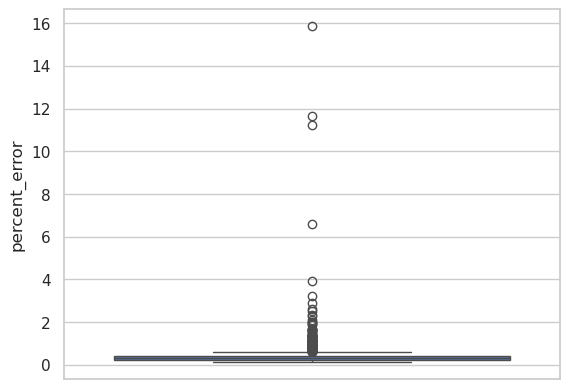

In [287]:
sns.boxplot(percent_error_by_station[~percent_error_by_station.isna()], y='percent_error')